In [35]:
#Import the libraries
import pandas as pd
import numpy as np
import pandas_datareader as web
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [36]:
#Get the data from yahoo finance
stock_ticker = 'aapl'
#FB
#AAPL
#AMZN
#NFLX
#GOOGL

# test = 1 -> time period 2000 to 2020
# test = 0 -> 2021 to now
def get_data(ticker, test):
    if test == 0:
      start = dt.datetime(2021, 1, 1)
      end = dt.datetime.now()
    else:
      start = dt.datetime(2000, 1, 1)
      end = dt.datetime(2020, 12, 31)
    
    df = web.DataReader(ticker,'yahoo', start, end)
    # Create Categorical Input 'Price Change' (Rise = 1, Fall = 0) from previous row Adj Close
    df['Price Change'] = df['Adj Close'].diff()
    df.loc[df['Price Change'] <= 0, 'Price Change'] = 0
    df.loc[df['Price Change'] > 0, 'Price Change'] = 1
    #remove the first row as price change is nan
    df = df[1:]
    return df

df = get_data(stock_ticker,1)
df

,High,Low,Open,Close,Volume,Adj Close,Price Change
Date,,,,,,,
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.788302,0.0
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.799837,1.0
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.730621,0.0
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.765229,1.0
2000-01-10,0.912946,0.845982,0.910714,0.872768,505064000.0,0.751771,0.0
...,...,...,...,...,...,...,...
2020-12-24,133.460007,131.100006,131.320007,131.970001,54930100.0,131.773087,1.0
2020-12-28,137.339996,133.509995,133.990005,136.690002,124486200.0,136.486053,1.0
2020-12-29,138.789993,134.339996,138.050003,134.869995,121047300.0,134.668762,0.0


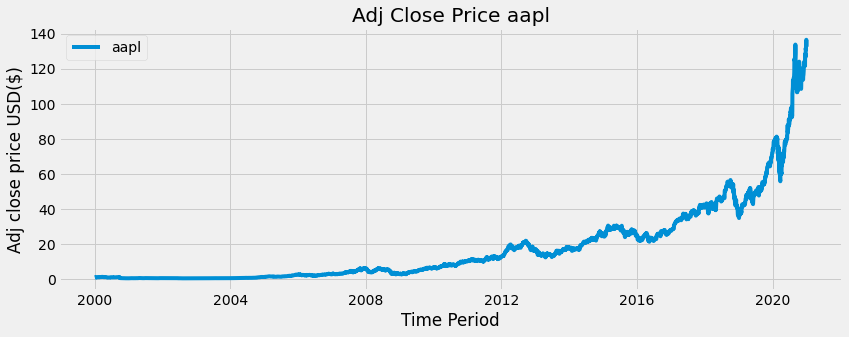

In [37]:
#visualize the data
plt.figure(figsize=(12.5,4.5))
plt.plot(df['Adj Close'], label = stock_ticker)

plt.title('Adj Close Price ' + stock_ticker)
plt.xlabel('Time Period')
plt.ylabel('Adj close price USD($)')
plt.legend(loc = 'upper left')
plt.show()

In [38]:
# Remove all non number
for col in df.columns: 
  df=df[pd.to_numeric(df[col], errors='coerce').notnull()]
# Remove NA
df = df.dropna()

#Preprocess data to fit into LSTM Model

In [39]:
# prepare data for lstm
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = df.values

# ensure all data is float
values = values.astype('float32')

# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
reframed.drop(reframed.columns[[10,9,8,7,11,12]], axis=1, inplace=True)
print(reframed.head())
values = reframed.values
values

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var6(t-1)  var7(t-1)  var7(t)
1   0.987723   0.903460   0.966518  ...   0.788302        0.0      1.0
2   0.987165   0.919643   0.926339  ...   0.799837        1.0      0.0
3   0.955357   0.848214   0.947545  ...   0.730621        0.0      1.0
4   0.901786   0.852679   0.861607  ...   0.765229        1.0      0.0
5   0.912946   0.845982   0.910714  ...   0.751771        0.0      0.0

[5 rows x 8 columns]


array([[  0.987723 ,   0.90346  ,   0.966518 , ...,   0.7883018,
          0.       ,   1.       ],
       [  0.987165 ,   0.919643 ,   0.926339 , ...,   0.7998371,
          1.       ,   0.       ],
       [  0.955357 ,   0.848214 ,   0.947545 , ...,   0.7306205,
          0.       ,   1.       ],
       ...,
       [137.34     , 133.51     , 133.99     , ..., 136.48605  ,
          1.       ,   0.       ],
       [138.79     , 134.34     , 138.05     , ..., 134.66876  ,
          0.       ,   0.       ],
       [135.99     , 133.4      , 135.58     , ..., 133.52048  ,
          0.       ,   0.       ]], dtype=float32)

In [40]:
# ensure all data is float
values = values.astype('float32')

# split into train and test sets (80% train)
train_size = round(0.8 * len(values))
train = values[:train_size, :]
test = values[train_size:, :]

# split into input and outputs (last column is Y)
train_X, train_y = train[:, :-1], train[:, -1]
print(train_X[:3])
print(train_y[:3])
test_X, test_y = test[:, :-1], test[:, -1]

# preprocess
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(train_X)
train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X) 

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


[[9.877230e-01 9.034600e-01 9.665180e-01 9.151790e-01 5.123776e+08
  7.883018e-01 0.000000e+00]
 [9.871650e-01 9.196430e-01 9.263390e-01 9.285710e-01 7.783216e+08
  7.998371e-01 1.000000e+00]
 [9.553570e-01 8.482140e-01 9.475450e-01 8.482140e-01 7.679728e+08
  7.306205e-01 0.000000e+00]]
[1. 0. 1.]
(4226, 1, 7) (4226,) (1056, 1, 7) (1056,)


#Load Model and Compile

In [41]:
 # load json and create model
from keras.models import model_from_json

json_file = open('model1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model1.h5")
print("Loaded model from disk")
model.compile(loss='Huber', optimizer='adam')


Loaded model from disk


#Results on Train and Test

In [42]:
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error


# TRAIN SET
yhat = model.predict(train_X)
y_pred = (yhat > 0.5)
cm = confusion_matrix(train_y, y_pred)
acc = (cm[0,0] + cm[1,1]) / sum(sum(cm)) * 100
print("TrainSet Accuracy %.2f%%" % acc)

# calculate RMSE
rmse = math.sqrt(mean_squared_error(train_y, yhat))
print('Train RMSE: %.3f' % rmse)



# TEST SET
yhat = model.predict(test_X)
y_pred = (yhat > 0.5)
cm = confusion_matrix(test_y, y_pred)
acc = (cm[0,0] + cm[1,1]) / sum(sum(cm)) * 100
print("TestSet Accuracy %.2f%%" % acc)

# calculate RMSE
rmse = math.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)



TrainSet Accuracy 49.74%
Train RMSE: 0.503
TestSet Accuracy 45.36%
Test RMSE: 0.505


#Backtesting 

In [43]:
# split into input and outputs (last column is Y)
df = get_data(stock_ticker, 1)

df = df.reset_index()
date = pd.DataFrame(df['Date'], columns=['Date'])
df.drop('Date', inplace=True, axis=1)
values = df.values
# preprocess

reframed = series_to_supervised(values, 1, 1)
reframed.drop(reframed.columns[[10,9,8,7,11,12]], axis=1, inplace=True)
print(reframed)
values = reframed.values
values = values.astype('float32')
print(values)
from sklearn import preprocessing

x = values[:,:-1]
y = values[:, -1]
scaler = preprocessing.StandardScaler().fit(x)
x = scaler.transform(x)
x = x.reshape((x.shape[0], 1, x.shape[1]))
x.shape


       var1(t-1)   var2(t-1)   var3(t-1)  ...   var6(t-1)  var7(t-1)  var7(t)
1       0.987723    0.903460    0.966518  ...    0.788302        0.0      1.0
2       0.987165    0.919643    0.926339  ...    0.799837        1.0      0.0
3       0.955357    0.848214    0.947545  ...    0.730621        0.0      1.0
4       0.901786    0.852679    0.861607  ...    0.765229        1.0      0.0
5       0.912946    0.845982    0.910714  ...    0.751771        0.0      0.0
...          ...         ...         ...  ...         ...        ...      ...
5278  132.429993  130.779999  132.160004  ...  130.764603        0.0      1.0
5279  133.460007  131.100006  131.320007  ...  131.773087        1.0      1.0
5280  137.339996  133.509995  133.990005  ...  136.486053        1.0      0.0
5281  138.789993  134.339996  138.050003  ...  134.668762        0.0      0.0
5282  135.990005  133.399994  135.580002  ...  133.520477        0.0      0.0

[5282 rows x 8 columns]
[[  0.987723    0.90346     0.966518  .

(5282, 1, 7)

In [44]:
import math
parameter = 0.5
# make a prediction
yhat = model.predict(x)
# store in Results DataFrame
results = pd.DataFrame(yhat, columns=['Result'])
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y, yhat))
print('RMSE: %.3f' % rmse)

y_pred = (yhat > parameter)
cm = confusion_matrix(y, y_pred)
acc = (cm[0,0] + cm[1,1]) / sum(sum(cm)) * 100
print("Accuracy %.2f%%" % acc)

#When predicted is > 0.5, buy at open. sell at close.
#Starting Capital $1000
#Results

capital = 1000

results['Open']=df['Open']
results['Close'] = df['Close']
results['LSTM'] = capital
results['Buy&Hold'] = capital
results['Date'] = date['Date']

for i in range(1,len(results)):
  if (results.iloc[i,0] < parameter):# if less than 0.5, do nothing and retain the previous day capital
    results.iloc[i, 3] = results.iloc[i-1,3] 
  else: # buy at open price with all capital and sell at close
    results.iloc[i, 3] = results.iloc[i-1, 3] / results.iloc[i, 1] * results.iloc[i, 2] 

number_of_shares = capital / results.iloc[0][1]

for i in range(1,len(results)):
  results.iloc[i,4] = number_of_shares * results.iloc[i,2]

profit = number_of_shares*results.iloc[-1][2] - capital


final_value = results.iloc[-1][3]
alpha = final_value-capital
print("========================================")
print("Initial Capital: $",capital)
print("========================================")
print("LSTM trading strategy Profits: $%.2f" % alpha)
print("Percentage Gain: %.2f%%" % (alpha/capital*100))
#Buy and Hold (Buy at Open price, Sell at Close Price)
print("========================================")
print("Profits from Buy and Hold $%.2f" % profit)
print("Percentage Gain: %.2f%%" % (profit/capital*100))
results = results.set_index('Date')
results

RMSE: 0.502
Accuracy 48.50%
Initial Capital: $ 1000
LSTM trading strategy Profits: $599438.20
Percentage Gain: 59943.82%
Profits from Buy and Hold $137352.32
Percentage Gain: 13735.23%


,Result,Open,Close,LSTM,Buy&Hold
Date,,,,,
2000-01-04,0.465649,0.966518,0.915179,1000.000000,1000.000000
2000-01-05,0.419827,0.926339,0.928571,1000.000000,960.738445
2000-01-06,0.494816,0.947545,0.848214,1000.000000,877.597710
2000-01-07,0.473203,0.861607,0.888393,1000.000000,919.168602
2000-01-10,0.466485,0.910714,0.872768,1000.000000,903.002322
...,...,...,...,...,...
2020-12-23,0.457565,132.160004,130.960007,600438.199281,135496.709595
2020-12-24,0.480924,131.320007,131.970001,600438.199281,136541.692226
2020-12-28,0.479992,133.990005,136.690002,600438.199281,141425.203236


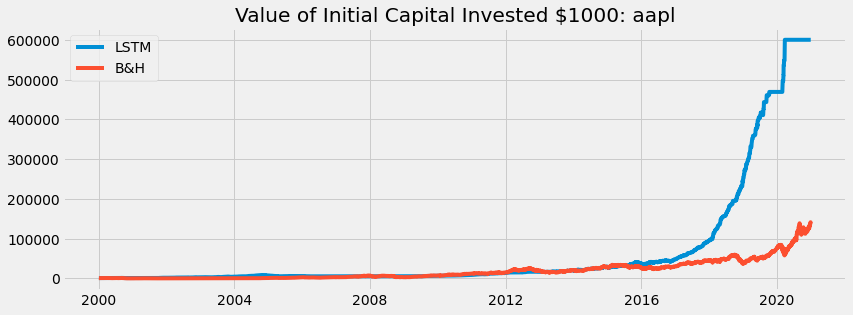

In [45]:
#Visualize Results
plt.figure(figsize=(12.5,4.5))
plt.plot(results['LSTM'], label='LSTM')
plt.plot(results['Buy&Hold'], label='B&H')
plt.title('Value of Initial Capital Invested $' + str(capital) +': ' +stock_ticker)

plt.legend()
plt.show()


In [46]:
if (alpha>profit):
  print("YES")
else:
  print("nope")

YES


#Test on 2021

In [47]:

# split into input and outputs (last column is Y)
df = get_data(stock_ticker, 0)

df = df.reset_index()
date = pd.DataFrame(df['Date'], columns=['Date'])
df.drop('Date', inplace=True, axis=1)
values = df.values
# preprocess

reframed = series_to_supervised(values, 1, 1)
reframed.drop(reframed.columns[[10,9,8,7,11,12]], axis=1, inplace=True)
values = reframed.values
#values = values.astype('float32')

from sklearn import preprocessing

x = values[:,:-1]
y = values[:, -1]
scaler = preprocessing.StandardScaler().fit(x)
x = scaler.transform(x)
x = x.reshape((x.shape[0], 1, x.shape[1]))
x.shape



import math
# make a prediction
yhat = model.predict(x)
# store in Results DataFrame
results = pd.DataFrame(yhat, columns=['Result'])
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y, yhat))
print('RMSE: %.3f' % rmse)

y_pred = (yhat > parameter)
cm = confusion_matrix(y, y_pred)
acc = (cm[0,0] + cm[1,1]) / sum(sum(cm)) * 100
print("Accuracy %.2f%%" % acc)

#When predicted is > parameter, buy at open. sell at close.
#Starting Capital $1000
#Results

capital = 1000

results['Open']=df['Open']
results['Close'] = df['Close']
results['LSTM'] = capital
results['Buy&Hold'] = capital
results['Date'] = date['Date']

for i in range(1,len(results)):
  if (results.iloc[i,0] < parameter):
    results.iloc[i, 3] = results.iloc[i-1,3] #if less than 0.5, do nothing and retain the previous day capital
  else:
    results.iloc[i, 3] = results.iloc[i-1, 3] / results.iloc[i, 1] * results.iloc[i, 2] #buy at open price with all capital and sell at close

number_of_shares = capital / results.iloc[0][1]

for i in range(1,len(results)):
  results.iloc[i,4] = number_of_shares * results.iloc[i,2]

profit = number_of_shares*results.iloc[-1][2] - capital


final_value = results.iloc[-1][3]
alpha = final_value-capital
print("========================================")
print("LSTM trading strategy Profits: $%.2f" % alpha)
print("Percentage Gain: %.2f%%" % (alpha/capital*100))
#Buy and Hold (Buy at Open price, Sell at Close Price)
print("========================================")
print("Profits from Buy and Hold $%.2f" % profit)
print("Percentage Gain: %.2f%%" % (profit/capital*100))



RMSE: 0.511
Accuracy 41.67%
LSTM trading strategy Profits: $-37.44
Percentage Gain: -3.74%
Profits from Buy and Hold $-52.29
Percentage Gain: -5.23%


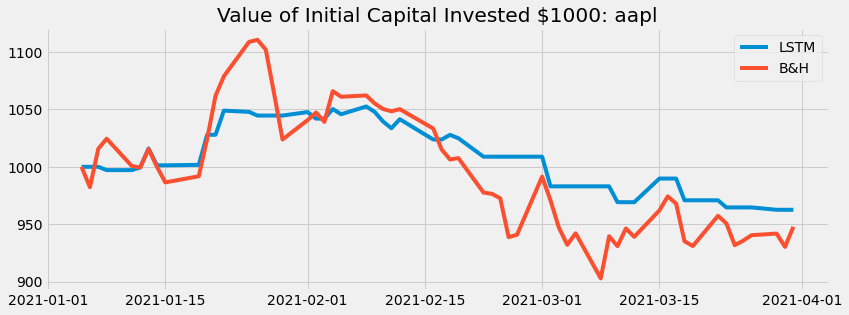

YES


In [48]:
#Visualize Results
results = results.set_index('Date')
plt.figure(figsize=(12.5,4.5))
plt.plot(results['LSTM'], label='LSTM')
plt.plot(results['Buy&Hold'], label='B&H')
plt.title('Value of Initial Capital Invested $' + str(capital) +': ' +stock_ticker)

plt.legend()
plt.show()

results.head()

if (alpha>profit):
  print("YES")
else:
  print("NOPE")

In [49]:
df = get_data(stock_ticker, 0)
print(df.columns
      )

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'Price Change'], dtype='object')


In [50]:
df = get_data(stock_ticker, 0)
df = df.iloc[-9:]
print(df)
df = df.reset_index()
date = pd.DataFrame(df['Date'], columns=['Date'])
df.drop('Date', inplace=True, axis=1)
values = df.values

reframed = series_to_supervised(values, 1, 1)
reframed.drop(reframed.columns[[10,9,8,7,11,12]], axis=1, inplace=True)
print(reframed)
values = reframed.values
#values = values.astype('float32')

from sklearn import preprocessing

x = values[:,:-1]
y = values[:, -1]
scaler = preprocessing.StandardScaler().fit(x)
x = scaler.transform(x)
x = x.reshape((x.shape[0], 1, x.shape[1]))
print(x.shape)
import math
# make a prediction
yhat = model.predict(x)
# store in Results DataFrame
results = pd.DataFrame(yhat, columns=['Result'])
print(results)

y_pred = (yhat > parameter)
cm = confusion_matrix(y, y_pred)
acc = (cm[0,0] + cm[1,1]) / sum(sum(cm)) * 100
print("Accuracy %.2f%%" % acc)

                  High         Low  ...   Adj Close  Price Change
Date                                ...                          
2021-03-22  123.870003  120.260002  ...  123.389999           1.0
2021-03-23  124.239998  122.139999  ...  122.540001           0.0
2021-03-24  122.900002  120.070000  ...  120.089996           0.0
2021-03-25  121.660004  119.000000  ...  120.589996           1.0
2021-03-26  121.480003  118.919998  ...  121.209999           1.0
2021-03-29  122.580002  120.730003  ...  121.389999           1.0
2021-03-30  120.400002  118.860001  ...  119.900002           0.0
2021-03-31  123.519997  121.150002  ...  122.150002           1.0
2021-04-01  124.180000  122.489998  ...  123.000000           1.0

[9 rows x 7 columns]
    var1(t-1)   var2(t-1)   var3(t-1)  ...   var6(t-1)  var7(t-1)  var7(t)
1  123.870003  120.260002  120.330002  ...  123.389999        1.0      0.0
2  124.239998  122.139999  123.330002  ...  122.540001        0.0      0.0
3  122.900002  120.070000  

#Trade Signal

In [51]:
#Number of days to generate trade signal
n = 51
df = get_data(stock_ticker, 0)
df = df.iloc[-n:]

values = df.values

reframed = series_to_supervised(values, 1, 1)
reframed.drop(reframed.columns[[0,1,2,3,4,5,6]], axis=1, inplace=True)
print(reframed)
values = reframed.values
#values = values.astype('float32')
from sklearn import preprocessing
x = values[:,:]

scaler = preprocessing.StandardScaler().fit(x)
x = scaler.transform(x)
x = x.reshape((x.shape[0], 1, x.shape[1]))

import math
# make a prediction
yhat = model.predict(x)
print("Result based on",n,"days:",yhat[-1])
print("==============================")
if (yhat[-1]>0.5):
  print("BUY")
else:
  print("Do nothing")

       var1(t)     var2(t)     var3(t)  ...      var5(t)     var6(t)  var7(t)
1   139.669998  133.589996  133.800003  ...  120529500.0  136.665771      1.0
2   139.850006  135.020004  136.279999  ...  114459400.0  138.862503      1.0
3   145.089996  136.539993  143.070007  ...  157611700.0  142.706757      1.0
4   144.300003  141.369995  143.600006  ...   98390600.0  142.946396      1.0
5   144.300003  140.410004  143.429993  ...  140843800.0  141.848038      0.0
6   141.990005  136.699997  139.520004  ...  142621100.0  136.885452      0.0
7   136.740005  130.210007  135.830002  ...  177180600.0  131.763107      0.0
8   135.380005  130.929993  133.750000  ...  106239800.0  133.939850      1.0
9   136.309998  134.610001  135.729996  ...   83305400.0  134.788589      1.0
10  135.770004  133.610001  135.759995  ...   89880900.0  133.740158      0.0
11  137.399994  134.589996  136.300003  ...   84183100.0  137.184998      1.0
12  137.419998  135.860001  137.350006  ...   75524000.0  136.75